In [3]:
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import random, argparse, pickle,cv2
from deepImageHomography import plotImage_with_draw
from deepImageHomography import plotImage

In [9]:
def createData(imagePath,typeData):
    if(typeData == 'train'):
        # Train image size: 240x320 with rho = 32
        height = 240
        width = 320
        rho = 32
        sizePatch = 128
    elif(typeData == 'test'):
        # Test image size: 480x640 with rho = 64
        height = 480
        width = 640
        rho = 64
        sizePatch = 256

    #--Resize loaded image--#
    image = cv2.imread(imagePath,0)                         # Read image
    image = cv2.resize(image,(width,height))                # Resize image

    #--Random point in image--#
    x = random.randint(rho, width - rho - sizePatch)        # not exceed horizontal borders
    y = random.randint(rho, height - rho - sizePatch)       # not exceed vertical borders

    #--Draw the square--#
    point1 = (x, y)                                         # top-left
    point2 = (x + sizePatch, y)                             # top-right
    point3 = (x, y + sizePatch)                             # bottom-left
    point4 = (x + sizePatch, y + sizePatch)                 # bottom-right
    imageCorners = np.array([point1,point2,point4,point3])

    #--Get patches--#
    Ip = image[ y:y + sizePatch, x:x + sizePatch ]                  # Patch of original image
    randomPerturb = np.random.randint(low=-rho,high=rho,size=(4,2)) # Random values for perturbation
    imagePerturbedCorners = imageCorners + randomPerturb    # Perturb square randomly
    H = cv2.getPerspectiveTransform(np.float32(imageCorners), \
        np.float32(imagePerturbedCorners))                  # Homography, H
    H_inv = np.linalg.inv(H)                                # H^(-1)
    imageWarped_H = cv2.warpPerspective(image, H, (width,height))

    imageWarped = cv2.warpPerspective(image, H_inv, (width,height)) # Warp image using H^(-1)
    Ip_prime = imageWarped[ y:y + sizePatch, x:x + sizePatch ]      # Patch of perturbed image

    #--Features & Labels for network--#
    imageFeature = np.dstack((Ip,Ip_prime))                 # 2-channel image
    H_4point = imagePerturbedCorners - imageCorners         # 4-point matrix

    #--For DEMO of data created--#
    homographyData = [image, imageWarped_H, Ip, Ip_prime,\
                        imageCorners, imagePerturbedCorners]

    return imageFeature, H_4point.flatten(), homographyData    # Data Set, sample patch and patch points

In [23]:
imageSet = glob("sample_images/*.jpg")
image = imageSet[3]
feature,label,data = createData(image,'train')

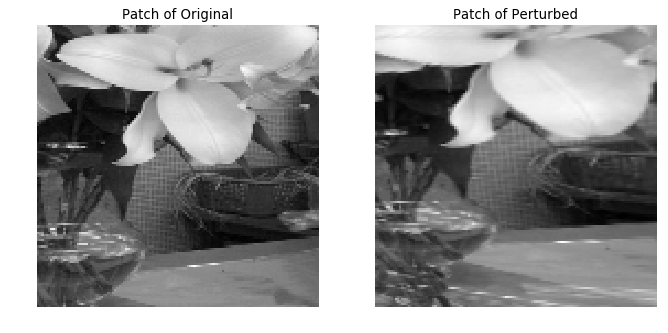

H_4point:  [ 19   8 -29  26 -30  11 -13  30]


In [20]:
fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plotImage(feature[:,:,0],'Patch of Original')
plt.subplot(122)
plotImage(feature[:,:,1],'Patch of Perturbed')
plt.show()

print("H_4point: ", label)

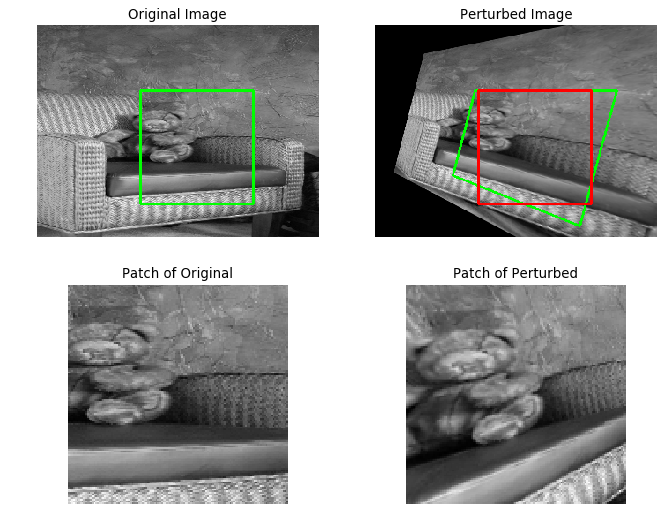

In [25]:
fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
image1 = cv2.cvtColor(data[0],cv2.COLOR_GRAY2RGB)
image2 = cv2.cvtColor(data[1],cv2.COLOR_GRAY2RGB)
plt.subplot(223)
plotImage(data[2],'Patch of Original')
plt.subplot(224)
plotImage(data[3],'Patch of Perturbed')
plt.subplot(221)
plotImage_with_draw(image1,[data[4]],'Original Image')
plt.subplot(222)
plotImage_with_draw(image2,[data[5],data[4]],'Perturbed Image')
plt.show()
plt.close()

In [14]:
print("-- GENERATE DATA --\n")

H_features = []
H_labels = []

number_of_samples = 200

for dataCount in range(number_of_samples):

    image = imageSet[random.randint(0,len(imageSet)-1)]                 # Randomly pick images in folder
    feature,label,_ = createData(image, 'train')   # Patches + 4-point
    H_features.append(feature)          # (128,128,2)
    H_labels.append(label)              # (8,1)

    if( ((dataCount+1) % 200 == 0) ):
        print("{} samples generated".format(dataCount+1))

print("{} samples generated".format(dataCount+1))

-- GENERATE DATA --

200 samples generated
200 samples generated


In [8]:
H_features = np.stack(H_features)       # Concatenate features
H_labels = np.stack(H_labels)           # Concatenate labels
H_data = [H_features,H_labels]          # Save features and labels in list

filename = 'sample.p'

pkl_file = open(filename,"wb")     # Save to pickle
pickle.dump(H_data,pkl_file)
pkl_file.close()                        # Close pickle file

print("-- Data set generation FINISHED --")

-- Data set generation FINISHED --
